In [3]:
#pip install pytorch-tabnet

In [4]:
#pip install torch

In [11]:
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import optuna
import pickle

from sklearn.base import BaseEstimator,TransformerMixin, ClassifierMixin
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV, RandomizedSearchCV, validation_curve
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder, PolynomialFeatures, StandardScaler, SplineTransformer, KBinsDiscretizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, f1_score, roc_curve, auc, recall_score, precision_recall_curve, make_scorer, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.kernel_approximation import Nystroem
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier

from pickle import dump, load

# Pytorch modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from torchviz import make_dot, make_dot_from_trace
from tqdm.notebook import tqdm
import tqdm

from pytorch_tabnet.tab_model import TabNetClassifier

from optuna.samplers import TPESampler

In [12]:
file = open('../../../conf/global_conf.yml', 'r') 
conf = yaml.safe_load(file)
df = pd.read_csv(conf['local_data_path'] + "data_cleaned_final_sans_dummies.csv",index_col=0,low_memory=False)

# Recodage variable cible grav par ordre croissant : 0 : indemne, 1 : blessé léger, 2 : blessé grave, 3 : décès
with pd.option_context("future.no_silent_downcasting", True):
    df['grav'] = df['grav'].replace(1,'I')
    df['grav'] = df['grav'].replace(2,'T')
    df['grav'] = df['grav'].replace(3,'BG')
    df['grav'] = df['grav'].replace(4,'BL')
    df['grav'] = df['grav'].replace('I',0)
    df['grav'] = df['grav'].replace('T',3)
    df['grav'] = df['grav'].replace('BG',2)
    df['grav'] = df['grav'].replace('BL',1)

data = df.drop(['grav_rec', 'an', 'jour', 'date', 'dep', 'grav'], axis=1)
y = df.grav.astype('int')

numerical_features = ['age_usager', 'mois', 'heure', 'lat', 'long']
categorical_features = [col for col in data.columns if col not in numerical_features]
for col in categorical_features:
    data[col] = data[col].astype('int')
data[categorical_features] = data[categorical_features].astype('int')


In [13]:
class TransfoHour(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        self.column_name = column_name

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transfo = X.copy()
        X_transfo[f'{self.column_name}_sin'] = np.sin(X_transfo[self.column_name]*(2.*np.pi/24))
        X_transfo[f'{self.column_name}_cos'] = np.cos(X_transfo[self.column_name]*(2.*np.pi/24))
        X_transfo = X_transfo.drop(self.column_name, axis=1)
        return X_transfo

    def get_feature_names_out(self):
        pass

class TransfoMonth(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        self.column_name = column_name

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transfo = X.copy()
        X_transfo[f'{self.column_name}_sin'] = np.sin((X_transfo[self.column_name]-1)*(2.*np.pi/12))
        X_transfo[f'{self.column_name}_cos'] = np.cos((X_transfo[self.column_name]-1)*(2.*np.pi/12))
        X_transfo = X_transfo.drop(self.column_name, axis=1)
        return X_transfo

    def get_feature_names_out(self):
        pass


preprocessor = ColumnTransformer(transformers=[
    ("transfo_heure", TransfoHour('heure'), ['heure']),
    ("transfo_mois", TransfoMonth('mois'), ['mois']),
    ("transfo_lat_long", RobustScaler(), ['lat', 'long']),
    ('transfo_age_usager', StandardScaler(), ['age_usager'])
    ],
    remainder="passthrough"
).set_output(transform="pandas")


In [14]:
data_train, data_test, y_train, y_test = train_test_split(data, y, test_size=0.3, random_state=42, stratify=y)
data_train, data_val, y_train, y_val = train_test_split(data_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

data_process_train = preprocessor.fit_transform(data_train)
data_process_val = preprocessor.transform(data_val)
data_process_test = preprocessor.transform(data_test)

data_process_train.head()

,transfo_heure__heure_sin,transfo_heure__heure_cos,transfo_mois__mois_sin,transfo_mois__mois_cos,transfo_lat_long__lat,transfo_lat_long__long,transfo_age_usager__age_usager,remainder__lum,remainder__agg,remainder__int,...,remainder__eq_ceinture,remainder__eq_casque,remainder__eq_siege,remainder__eq_gilet,remainder__eq_airbag,remainder__eq_gants,remainder__eq_indetermine,remainder__eq_autre,remainder__jour_chome,remainder__prox_pt_choc
367203,1.224647e-16,-1.000000,0.000000e+00,1.000000e+00,0.291093,0.027916,1.522566,0,1,0,...,0,0,0,0,0,0,1,0,1,0
165009,-9.659258e-01,-0.258819,8.660254e-01,-5.000000e-01,0.676458,-0.006907,0.193791,0,0,1,...,1,0,0,0,0,0,0,0,1,0
102923,-5.000000e-01,-0.866025,8.660254e-01,-5.000000e-01,0.271712,-0.046623,0.193791,0,1,1,...,0,1,0,0,0,1,0,0,1,1
389410,-8.660254e-01,-0.500000,1.000000e+00,6.123234e-17,0.201869,1.542802,-0.816077,0,1,1,...,1,0,0,0,0,0,1,0,0,0
85702,8.660254e-01,-0.500000,1.224647e-16,-1.000000e+00,-0.047079,-0.248779,0.937905,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [6]:
dump(preprocessor,open('../../../data/saved_models/' + 'preprocessor_tabnet.pkl','wb'))

In [9]:
scaler = load(open('../../../data/saved_models/' + 'preprocessor_tabnet.pkl','rb'))
data_process_val_verif = scaler.transform(data_val)
data_process_val_verif.head()

,transfo_heure__heure_sin,transfo_heure__heure_cos,transfo_mois__mois_sin,transfo_mois__mois_cos,transfo_lat_long__lat,transfo_lat_long__long,transfo_age_usager__age_usager,remainder__lum,remainder__agg,remainder__int,...,remainder__eq_ceinture,remainder__eq_casque,remainder__eq_siege,remainder__eq_gilet,remainder__eq_airbag,remainder__eq_gants,remainder__eq_indetermine,remainder__eq_autre,remainder__jour_chome,remainder__prox_pt_choc
1250,-5.000000e-01,-0.866025,-0.866025,5.000000e-01,0.269534,-0.031134,-0.178266,0,1,0,...,1,0,0,0,0,0,0,0,1,1
198605,1.224647e-16,-1.000000,-0.500000,8.660254e-01,0.003887,-1.665390,-1.134983,0,1,1,...,0,1,0,0,0,0,1,0,0,1
125556,8.660254e-01,0.500000,0.000000,1.000000e+00,-1.256697,2.055111,-0.709775,2,0,0,...,1,0,0,0,0,0,0,0,1,1
267349,-9.659258e-01,0.258819,1.000000,6.123234e-17,0.399773,-0.093836,-0.869228,0,1,1,...,1,0,0,0,0,0,0,0,0,0
383250,2.588190e-01,-0.965926,-0.866025,5.000000e-01,-0.688581,-0.885088,-1.719644,0,1,1,...,0,0,1,0,0,0,0,0,1,0


In [9]:
clf = TabNetClassifier(
    n_d=64, n_a=64, n_steps=10,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=0.1),
    scheduler_params = {"gamma": 0.95,
                     "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, 
    epsilon=1e-15
)

c:\Users\dcons\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [10]:
class_weights = []
for i in range(4):
  Nb_class = y_train[y_train == i].shape[0]
  class_weights.append(y_train.shape[0] / (4*Nb_class))
class_weights = [class_weights[i] for i in range(len(class_weights))]
dict_weights = {0:class_weights[0], 1:class_weights[1], 2:class_weights[2], 3:class_weights[3]}
dict_weights

{0: 0.6057227516686162,
 1: 0.6196819041752827,
 2: 1.5969466427810155,
 3: 9.161408872121765}

**OPtimisation des hyperparamètres avec Optuna**

In [11]:
def objective(trial):
    mask_type = trial.suggest_categorical('mask_type', ["entmax", "sparsemax"]) #masking function to use for selecting features
    n_da = trial.suggest_int("n_d", 56, 64, step=4) #Bigger values gives more capacity to the model with the risk of overfitting (between 8 and 64)
    n_steps = trial.suggest_int("n_steps", 1, 10, step=3) #nb of steps in the architecture
    gamma = trial.suggest_float("gamma", 1., 1.4, step=0.2) #gamma : coeff for feature reusage in the masks
    n_shared = trial.suggest_int("n_shared", 1, 3) # between 1 and 5, nb of shared GLU at each steps
    lambda_sparse = trial.suggest_float("lambda_sparse", 1e-6, 1e-3, log=True) #extra sparsity loss coefficient
    tabnet_params = dict(n_d=n_da, n_a=n_da, n_steps=n_steps, gamma=gamma,
                     lambda_sparse=lambda_sparse, optimizer_fn=torch.optim.Adam,
                     optimizer_params=dict(lr=0.1, weight_decay=1e-5),
                     mask_type=mask_type, 
                     n_shared=n_shared,
                     scheduler_params=dict(mode="min",
                                           patience=trial.suggest_int("patienceScheduler",low=3,high=10),
                                           min_lr=1e-5,
                                           factor=0.5,),
                     scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
                     verbose=0,
                     )
 

    model = TabNetClassifier(**tabnet_params)
    model.fit(
        X_train=data_process_train.to_numpy(), y_train=y_train.values,
        eval_set=[(data_process_train.to_numpy(), y_train.values), (data_process_val.to_numpy(), y_val.values)],
        eval_name=['train', 'valid'],
        eval_metric = ['balanced_accuracy'],
        max_epochs=trial.suggest_int('epochs', 1, 40), 
        patience=trial.suggest_int("patience",low=15,high=30),
        weights = dict_weights,
        batch_size=16384, 
        virtual_batch_size=trial.suggest_int("virtual_batch_size", 64,256,step=64)
) 
    preds = model.predict(data_process_val.to_numpy())
    cat_f1 = f1_score(preds, y_val, average = 'micro')
    return cat_f1

sampler = TPESampler(seed=123, multivariate=True, group=True)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=20, n_jobs=-1)

c:\Users\dcons\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\samplers\_tpe\sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
c:\Users\dcons\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\samplers\_tpe\sampler.py:330: ExperimentalWarning: ``group`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2024-06-10 16:48:55,676] A new study created in memory with name: no-name-21c550be-3dda-4d91-962e-21114e5d354e


Stop training because you reached max_epochs = 7 with best_epoch = 6 and best_valid_balanced_accuracy = 0.49806


c:\Users\dcons\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-06-10 17:16:04,375] Trial 4 finished with value: 0.4970607028753994 and parameters: {'mask_type': 'entmax', 'n_d': 60, 'n_steps': 4, 'gamma': 1.4, 'n_shared': 1, 'lambda_sparse': 9.527793179935937e-05, 'patienceScheduler': 3, 'epochs': 7, 'patience': 21, 'virtual_batch_size': 256}. Best is trial 4 with value: 0.4970607028753994.


Stop training because you reached max_epochs = 28 with best_epoch = 25 and best_valid_balanced_accuracy = 0.55536


c:\Users\dcons\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-06-10 20:16:25,075] Trial 6 finished with value: 0.568594249201278 and parameters: {'mask_type': 'sparsemax', 'n_d': 60, 'n_steps': 7, 'gamma': 1.0, 'n_shared': 2, 'lambda_sparse': 1.9230207284052763e-06, 'patienceScheduler': 5, 'epochs': 28, 'patience': 23, 'virtual_batch_size': 256}. Best is trial 6 with value: 0.568594249201278.


Stop training because you reached max_epochs = 14 with best_epoch = 13 and best_valid_balanced_accuracy = 0.55966


c:\Users\dcons\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-06-10 20:23:29,307] Trial 0 finished with value: 0.5828115015974441 and parameters: {'mask_type': 'entmax', 'n_d': 60, 'n_steps': 10, 'gamma': 1.0, 'n_shared': 2, 'lambda_sparse': 0.00024061480056217896, 'patienceScheduler': 6, 'epochs': 14, 'patience': 25, 'virtual_batch_size': 128}. Best is trial 0 with value: 0.5828115015974441.


Stop training because you reached max_epochs = 36 with best_epoch = 27 and best_valid_balanced_accuracy = 0.55961


c:\Users\dcons\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-06-10 20:54:35,936] Trial 1 finished with value: 0.5754952076677317 and parameters: {'mask_type': 'sparsemax', 'n_d': 60, 'n_steps': 4, 'gamma': 1.2, 'n_shared': 3, 'lambda_sparse': 0.00019732815617074526, 'patienceScheduler': 5, 'epochs': 36, 'patience': 26, 'virtual_batch_size': 192}. Best is trial 0 with value: 0.5828115015974441.


Stop training because you reached max_epochs = 4 with best_epoch = 1 and best_valid_balanced_accuracy = 0.3737


c:\Users\dcons\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-06-10 21:09:46,093] Trial 10 finished with value: 0.47527156549520766 and parameters: {'mask_type': 'sparsemax', 'n_d': 60, 'n_steps': 10, 'gamma': 1.0, 'n_shared': 1, 'lambda_sparse': 1.3920219139614885e-05, 'patienceScheduler': 6, 'epochs': 4, 'patience': 16, 'virtual_batch_size': 128}. Best is trial 0 with value: 0.5828115015974441.


Stop training because you reached max_epochs = 12 with best_epoch = 10 and best_valid_balanced_accuracy = 0.51916


c:\Users\dcons\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-06-10 21:48:13,026] Trial 9 finished with value: 0.5400958466453674 and parameters: {'mask_type': 'sparsemax', 'n_d': 60, 'n_steps': 4, 'gamma': 1.4, 'n_shared': 3, 'lambda_sparse': 5.996651392879352e-06, 'patienceScheduler': 4, 'epochs': 12, 'patience': 19, 'virtual_batch_size': 128}. Best is trial 0 with value: 0.5828115015974441.


Stop training because you reached max_epochs = 32 with best_epoch = 20 and best_valid_balanced_accuracy = 0.48029


c:\Users\dcons\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-06-10 21:51:37,379] Trial 2 finished with value: 0.49492012779552713 and parameters: {'mask_type': 'sparsemax', 'n_d': 56, 'n_steps': 10, 'gamma': 1.4, 'n_shared': 1, 'lambda_sparse': 0.0001380776602170474, 'patienceScheduler': 4, 'epochs': 32, 'patience': 28, 'virtual_batch_size': 192}. Best is trial 0 with value: 0.5828115015974441.


Stop training because you reached max_epochs = 5 with best_epoch = 4 and best_valid_balanced_accuracy = 0.47125


c:\Users\dcons\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-06-10 22:28:03,760] Trial 14 finished with value: 0.5054632587859424 and parameters: {'mask_type': 'entmax', 'n_d': 60, 'n_steps': 4, 'gamma': 1.2, 'n_shared': 3, 'lambda_sparse': 0.0004964303188119987, 'patienceScheduler': 4, 'epochs': 5, 'patience': 26, 'virtual_batch_size': 128}. Best is trial 0 with value: 0.5828115015974441.


Stop training because you reached max_epochs = 11 with best_epoch = 10 and best_valid_balanced_accuracy = 0.49823


c:\Users\dcons\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-06-10 22:56:44,726] Trial 12 finished with value: 0.5275079872204473 and parameters: {'mask_type': 'sparsemax', 'n_d': 56, 'n_steps': 7, 'gamma': 1.2, 'n_shared': 2, 'lambda_sparse': 8.711858662845637e-05, 'patienceScheduler': 7, 'epochs': 11, 'patience': 17, 'virtual_batch_size': 128}. Best is trial 0 with value: 0.5828115015974441.


Stop training because you reached max_epochs = 27 with best_epoch = 17 and best_valid_balanced_accuracy = 0.55009


c:\Users\dcons\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-06-10 23:25:37,672] Trial 15 finished with value: 0.5777316293929713 and parameters: {'mask_type': 'sparsemax', 'n_d': 64, 'n_steps': 1, 'gamma': 1.0, 'n_shared': 2, 'lambda_sparse': 1.0526552923686196e-06, 'patienceScheduler': 10, 'epochs': 27, 'patience': 17, 'virtual_batch_size': 192}. Best is trial 0 with value: 0.5828115015974441.


Stop training because you reached max_epochs = 40 with best_epoch = 37 and best_valid_balanced_accuracy = 0.55376


c:\Users\dcons\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-06-11 01:00:34,330] Trial 3 finished with value: 0.5724281150159745 and parameters: {'mask_type': 'entmax', 'n_d': 60, 'n_steps': 7, 'gamma': 1.2, 'n_shared': 3, 'lambda_sparse': 2.8379999332854737e-06, 'patienceScheduler': 5, 'epochs': 40, 'patience': 16, 'virtual_batch_size': 128}. Best is trial 0 with value: 0.5828115015974441.


Stop training because you reached max_epochs = 33 with best_epoch = 30 and best_valid_balanced_accuracy = 0.53292


c:\Users\dcons\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-06-11 02:07:48,455] Trial 13 finished with value: 0.5529712460063898 and parameters: {'mask_type': 'sparsemax', 'n_d': 64, 'n_steps': 7, 'gamma': 1.2, 'n_shared': 1, 'lambda_sparse': 2.3182365635270526e-06, 'patienceScheduler': 8, 'epochs': 33, 'patience': 25, 'virtual_batch_size': 128}. Best is trial 0 with value: 0.5828115015974441.


Stop training because you reached max_epochs = 39 with best_epoch = 36 and best_valid_balanced_accuracy = 0.48855


c:\Users\dcons\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-06-11 02:15:27,807] Trial 16 finished with value: 0.5117571884984026 and parameters: {'mask_type': 'sparsemax', 'n_d': 56, 'n_steps': 7, 'gamma': 1.4, 'n_shared': 1, 'lambda_sparse': 6.566748019798654e-06, 'patienceScheduler': 9, 'epochs': 39, 'patience': 23, 'virtual_batch_size': 256}. Best is trial 0 with value: 0.5828115015974441.


Stop training because you reached max_epochs = 34 with best_epoch = 18 and best_valid_balanced_accuracy = 0.54721


c:\Users\dcons\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-06-11 03:07:44,416] Trial 19 finished with value: 0.5871246006389776 and parameters: {'mask_type': 'sparsemax', 'n_d': 64, 'n_steps': 1, 'gamma': 1.0, 'n_shared': 2, 'lambda_sparse': 2.039967147993132e-06, 'patienceScheduler': 10, 'epochs': 34, 'patience': 21, 'virtual_batch_size': 192}. Best is trial 19 with value: 0.5871246006389776.


Stop training because you reached max_epochs = 31 with best_epoch = 28 and best_valid_balanced_accuracy = 0.5416


c:\Users\dcons\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 36 with best_epoch = 26 and best_valid_balanced_accuracy = 0.55789


c:\Users\dcons\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-06-11 03:31:25,024] Trial 18 finished with value: 0.570926517571885 and parameters: {'mask_type': 'sparsemax', 'n_d': 60, 'n_steps': 4, 'gamma': 1.0, 'n_shared': 2, 'lambda_sparse': 2.611852337589114e-06, 'patienceScheduler': 9, 'epochs': 36, 'patience': 16, 'virtual_batch_size': 192}. Best is trial 19 with value: 0.5871246006389776.
[I 2024-06-11 03:32:50,303] Trial 8 finished with value: 0.5618210862619808 and parameters: {'mask_type': 'entmax', 'n_d': 56, 'n_steps': 7, 'gamma': 1.2, 'n_shared': 3, 'lambda_sparse': 0.00032487339657501343, 'patienceScheduler': 7, 'epochs': 31, 'patience': 21, 'virtual_batch_size': 64}. Best is trial 19 with value: 0.5871246006389776.


Stop training because you reached max_epochs = 25 with best_epoch = 22 and best_valid_balanced_accuracy = 0.46848


c:\Users\dcons\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-06-11 03:55:02,582] Trial 5 finished with value: 0.4740894568690096 and parameters: {'mask_type': 'entmax', 'n_d': 60, 'n_steps': 10, 'gamma': 1.4, 'n_shared': 3, 'lambda_sparse': 8.967929835856829e-06, 'patienceScheduler': 3, 'epochs': 25, 'patience': 23, 'virtual_batch_size': 64}. Best is trial 19 with value: 0.5871246006389776.


Stop training because you reached max_epochs = 24 with best_epoch = 19 and best_valid_balanced_accuracy = 0.53467


c:\Users\dcons\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-06-11 04:08:08,034] Trial 17 finished with value: 0.569552715654952 and parameters: {'mask_type': 'entmax', 'n_d': 60, 'n_steps': 7, 'gamma': 1.2, 'n_shared': 2, 'lambda_sparse': 0.00026780022953582655, 'patienceScheduler': 7, 'epochs': 24, 'patience': 26, 'virtual_batch_size': 64}. Best is trial 19 with value: 0.5871246006389776.


Stop training because you reached max_epochs = 36 with best_epoch = 30 and best_valid_balanced_accuracy = 0.56453


c:\Users\dcons\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-06-11 04:36:58,350] Trial 11 finished with value: 0.5804153354632587 and parameters: {'mask_type': 'entmax', 'n_d': 56, 'n_steps': 7, 'gamma': 1.0, 'n_shared': 3, 'lambda_sparse': 6.952399023914924e-06, 'patienceScheduler': 5, 'epochs': 36, 'patience': 21, 'virtual_batch_size': 64}. Best is trial 19 with value: 0.5871246006389776.


Stop training because you reached max_epochs = 37 with best_epoch = 21 and best_valid_balanced_accuracy = 0.48345


c:\Users\dcons\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-06-11 04:45:56,081] Trial 7 finished with value: 0.492332268370607 and parameters: {'mask_type': 'entmax', 'n_d': 56, 'n_steps': 10, 'gamma': 1.4, 'n_shared': 3, 'lambda_sparse': 9.63344725015354e-05, 'patienceScheduler': 5, 'epochs': 37, 'patience': 18, 'virtual_batch_size': 64}. Best is trial 19 with value: 0.5871246006389776.


In [12]:
optuna.visualization.plot_parallel_coordinate(study)

In [13]:
optuna.visualization.plot_param_importances(study)

In [14]:
study.best_params

{'mask_type': 'sparsemax',
 'n_d': 64,
 'n_steps': 1,
 'gamma': 1.0,
 'n_shared': 2,
 'lambda_sparse': 2.039967147993132e-06,
 'patienceScheduler': 10,
 'epochs': 34,
 'patience': 21,
 'virtual_batch_size': 192}

In [17]:
best_model = study.best_trial
best_model

FrozenTrial(number=19, state=1, values=[0.5871246006389776], datetime_start=datetime.datetime(2024, 6, 11, 2, 7, 48, 485466), datetime_complete=datetime.datetime(2024, 6, 11, 3, 7, 44, 413792), params={'mask_type': 'sparsemax', 'n_d': 64, 'n_steps': 1, 'gamma': 1.0, 'n_shared': 2, 'lambda_sparse': 2.039967147993132e-06, 'patienceScheduler': 10, 'epochs': 34, 'patience': 21, 'virtual_batch_size': 192}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'mask_type': CategoricalDistribution(choices=('entmax', 'sparsemax')), 'n_d': IntDistribution(high=64, log=False, low=56, step=4), 'n_steps': IntDistribution(high=10, log=False, low=1, step=3), 'gamma': FloatDistribution(high=1.4, log=False, low=1.0, step=0.2), 'n_shared': IntDistribution(high=3, log=False, low=1, step=1), 'lambda_sparse': FloatDistribution(high=0.001, log=True, low=1e-06, step=None), 'patienceScheduler': IntDistribution(high=10, log=False, low=3, step=1), 'epochs': IntDistribution(high=40, log=False, 

**Entraînement du meilleur modèle**

In [21]:
max_epochs = 34

best_model = TabNetClassifier(
    n_d=64, n_a=64, n_steps=1, n_shared=2,
    gamma=1.0,
    lambda_sparse=2.039967147993132e-06,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=0.1, weight_decay=1e-5),
    mask_type='sparsemax', 
    scheduler_params = dict(mode="min", patience=10, min_lr=1e-5, factor=0.5),
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau, 
    epsilon=1e-15
)

best_model.fit(
    X_train=data_process_train.to_numpy(), y_train=y_train.values,
    eval_set=[(data_process_train.to_numpy(), y_train.values), (data_process_val.to_numpy(), y_val.values)],
    eval_name=['train', 'valid'],
    eval_metric = ['balanced_accuracy'],
    max_epochs=max_epochs, 
    patience=21,
    weights = dict_weights,
    batch_size=16384, virtual_batch_size=192
) 

c:\Users\dcons\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning:

Device used : cpu



epoch 0  | loss: 1.3987  | train_balanced_accuracy: 0.37282 | valid_balanced_accuracy: 0.37348 |  0:00:22s
epoch 1  | loss: 1.10687 | train_balanced_accuracy: 0.3654  | valid_balanced_accuracy: 0.37009 |  0:00:44s
epoch 2  | loss: 1.05781 | train_balanced_accuracy: 0.41543 | valid_balanced_accuracy: 0.41518 |  0:01:06s
epoch 3  | loss: 1.03241 | train_balanced_accuracy: 0.41393 | valid_balanced_accuracy: 0.4163  |  0:01:27s
epoch 4  | loss: 1.01925 | train_balanced_accuracy: 0.42525 | valid_balanced_accuracy: 0.42499 |  0:01:48s
epoch 5  | loss: 1.00351 | train_balanced_accuracy: 0.44573 | valid_balanced_accuracy: 0.44515 |  0:02:08s
epoch 6  | loss: 0.99601 | train_balanced_accuracy: 0.47136 | valid_balanced_accuracy: 0.46877 |  0:02:29s
epoch 7  | loss: 0.98186 | train_balanced_accuracy: 0.50558 | valid_balanced_accuracy: 0.50196 |  0:02:51s
epoch 8  | loss: 0.97608 | train_balanced_accuracy: 0.50883 | valid_balanced_accuracy: 0.50443 |  0:03:11s
epoch 9  | loss: 0.9722  | train_bala

c:\Users\dcons\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning:

Best weights from best epoch are automatically used!



**Sauvegarde du modèle**

In [38]:
filename = conf['local_data_path'] + 'tabnet_model'
best_model.save_model(filename)  #extension non nécessaire


Successfully saved model at C:/Users/dcons/Documents/NADEGE/DATASCIENTEST/Projet/data/tabnet_model.zip


'C:/Users/dcons/Documents/NADEGE/DATASCIENTEST/Projet/data/tabnet_model.zip'

In [5]:
## Pour recharger le modèle
#filename = conf['local_data_path'] + 'tabnet_model.zip'
#loaded_model = TabNetClassifier()
#loaded_model.load_model(filename)

c:\Users\dcons\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


**Prédictions et performances**

In [22]:
y_pred = best_model.predict(data_process_test.to_numpy())

In [8]:
#y_pred = loaded_model.predict(data_process_test.to_numpy())

In [16]:
print("accuracy - train :", accuracy_score(loaded_model.predict(data_process_train.to_numpy()), y_train))
print("accuracy - test :", accuracy_score(y_pred, y_test))


accuracy - train : 0.6076430181579368
accuracy - test : 0.5956866282493793


In [70]:
print(classification_report(y_test, y_pred,target_names=['Indemnes', 'Blessés légers', 'Blessés graves', 'Tués']))

                precision    recall  f1-score   support

      Indemnes       0.72      0.78      0.75     55365
Blessés légers       0.67      0.46      0.55     54116
Blessés graves       0.38      0.46      0.42     21000
          Tués       0.15      0.45      0.22      3660

      accuracy                           0.60    134141
     macro avg       0.48      0.54      0.49    134141
  weighted avg       0.63      0.60      0.60    134141



In [37]:
cr= classification_report(y_test, y_pred, target_names=['Indemnes', 'Blessés légers', 'Blessés graves', 'Tués'],output_dict=True)
df_cr = pd.DataFrame(cr).transpose()
print(df_cr)
df_cr.to_csv('../../../data/img/' + 'tabnet_report' + '.csv')

                precision    recall  f1-score        support
Indemnes         0.723836  0.784250  0.752833   55365.000000
Blessés légers   0.667588  0.464188  0.547611   54116.000000
Blessés graves   0.379593  0.463429  0.417342   21000.000000
Tués             0.150060  0.446448  0.224620    3660.000000
accuracy         0.595687  0.595687  0.595687       0.595687
macro avg        0.480269  0.539579  0.485601  134141.000000
weighted avg     0.631597  0.595687  0.603107  134141.000000


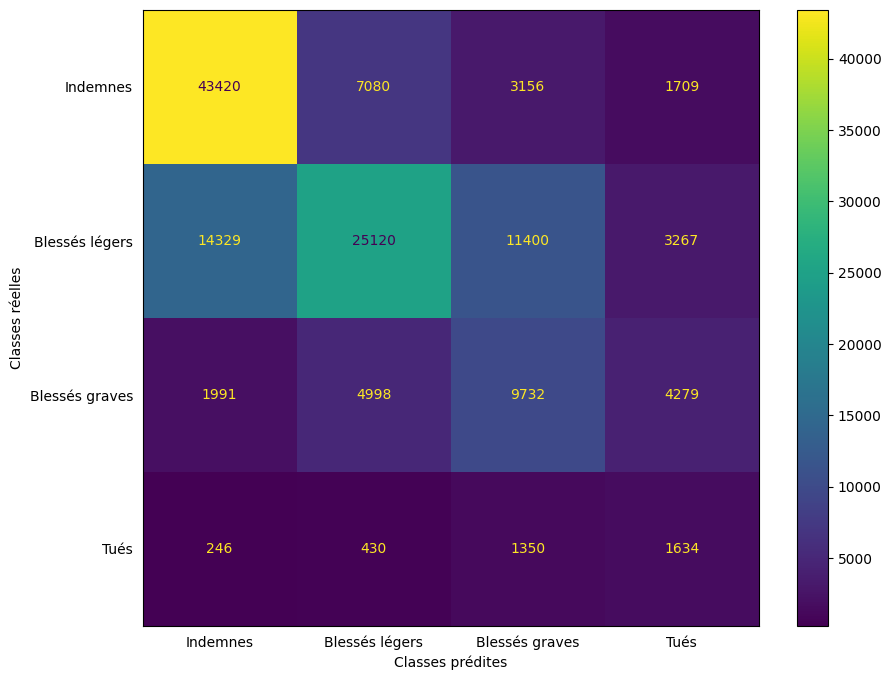

In [36]:
cm = confusion_matrix(y_test, y_pred) 
disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=['Indemnes', 'Blessés légers', 'Blessés graves', 'Tués']
    )

#disp.ax_.set(xlabel='Classes prédites', ylabel='Classes réelles')
disp.plot()
plt.xlabel('Classes prédites')
plt.ylabel('Classes réelles')
plt.tick_params(left = False, bottom = False) 
plt.rcParams["figure.figsize"] = (12, 8)
plt.savefig('../../../data/img/' + f'tabnet_confusion_matrix' + '.jpg')

In [71]:
cm2 = pd.crosstab(y_test, y_pred, rownames = ['Classe réelle'], colnames = ['Classe prédite'])
cm2

Classe prédite,0,1,2,3
Classe réelle,,,,
0,43420,7080,3156,1709
1,14329,25120,11400,3267
2,1991,4998,9732,4279
3,246,430,1350,1634


**Interprétabilité du modèle**

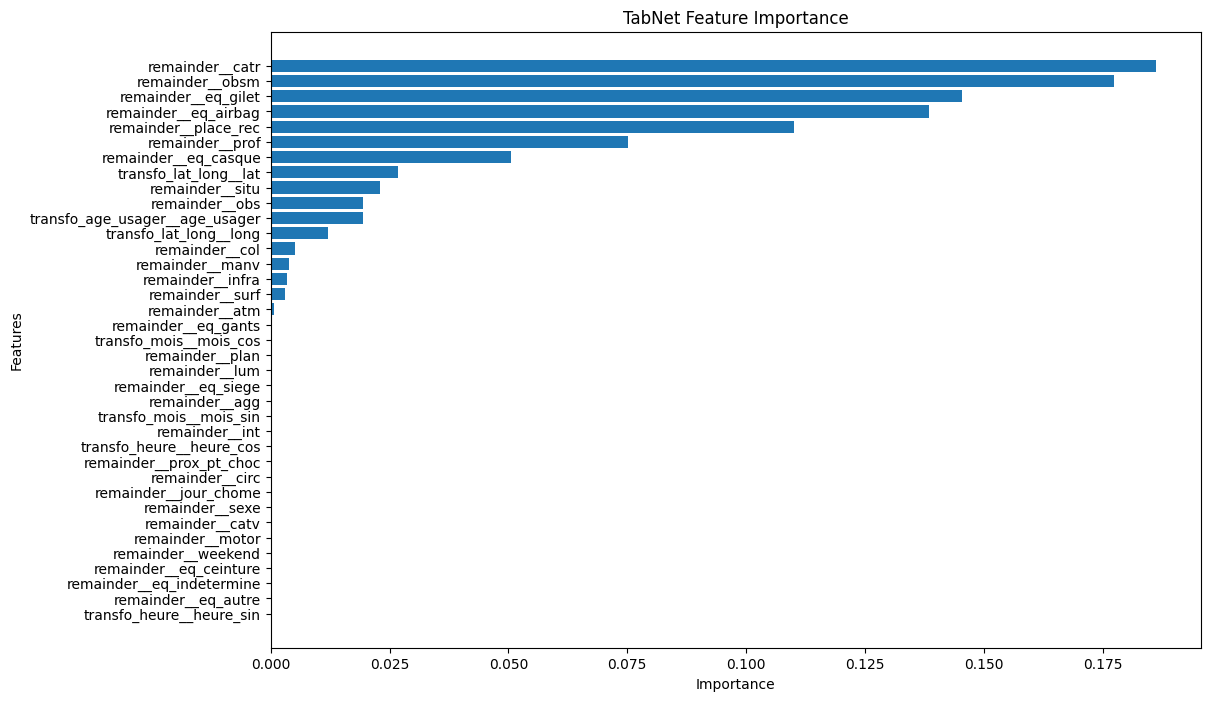

In [32]:
importances = best_model.feature_importances_
feature_importances = pd.Series(importances, index=data_process_test.columns).sort_values()
plt.figure(figsize=(12, 8))
plt.barh(feature_importances.index, feature_importances.values)
plt.title('TabNet Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.savefig('../../../data/img/' + f'tabnet_feature_importance' + '.jpg')

In [53]:
explain_matrix, masks = best_model.explain(data_process_test.to_numpy())

In [54]:
masks[0] #n_steps = 1 => 1 seule profondeur

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [58]:
print("nb d'échantillons :", len(masks[0]))
print("nb de variables :", len(masks[0][0]))

nb d'échantillons : 134141
nb de variables : 37


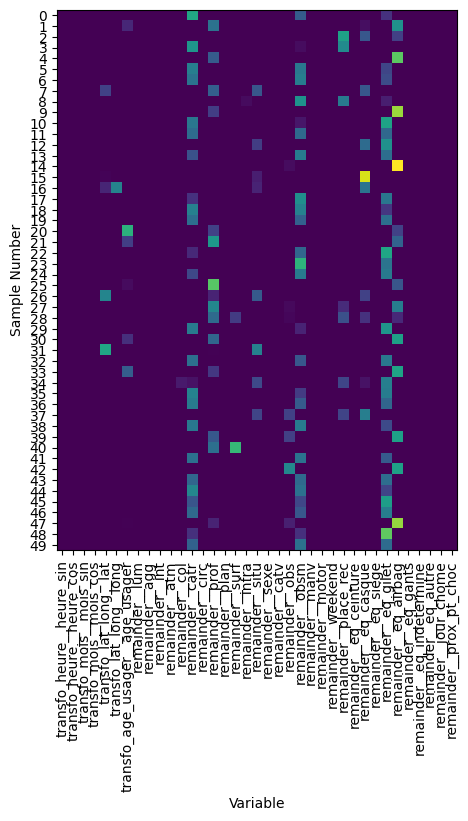

In [67]:
n_samples = 50

fig = plt.figure(figsize=(5,40))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
plt.yticks(np.arange(0, n_samples, 1.0))
plt.xticks(np.arange(0, len(masks[0][0]), 1.0))
ax.set_xticklabels(data_process_test.columns, rotation=90)
plt.ylabel('Sample Number')
plt.xlabel('Variable')
plt.imshow(masks[0][:n_samples])